<a href="https://colab.research.google.com/github/teja-1403/Cervical_Cancer-Detection-using-Python/blob/main/CCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

teja098_sipakmed_dataset_path = kagglehub.dataset_download('teja098/sipakmed-dataset')

print('Data source import complete.')


# **Cervical Cancer Detection using Python**

In [ ]:
# Install necessary libraries
!pip install opencv-python tensorflow keras scikit-image scikit-learn seaborn matplotlib

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import slic
from skimage.color import label2rgb
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# SLIC Segmentation
def apply_slic(image_path, num_segments=100):

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # SLIC
    segments = slic(img, n_segments=num_segments, compactness=10, start_label=1)

    superpixel_image = label2rgb(segments, img, kind='avg')
    # uint8
    superpixel_image = (superpixel_image * 255).astype(np.uint8)
    return superpixel_image

In [ ]:
def preprocess_dataset(input_dir, output_dir, num_segments=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        save_path = os.path.join(output_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                processed_img = apply_slic(img_path, num_segments)
                save_file = os.path.join(save_path, img_file)
                cv2.imwrite(save_file, processed_img)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
train_dir = "/kaggle/input/sipakmed-dataset/CCD/SingleCellPAP/Training"
test_dir = "/kaggle/input/sipakmed-dataset/CCD/SingleCellPAP/Test"

processed_train_dir = "/kaggle/working/processed_Training"
processed_test_dir = "/kaggle/working/processed_Test"

preprocess_dataset(train_dir, processed_train_dir, num_segments=100)
preprocess_dataset(test_dir, processed_test_dir, num_segments=100)

In [ ]:
# Canny Edge Detection
def apply_edge_detection_on_superpixel(superpixel_img):
    gray = cv2.cvtColor(superpixel_img, cv2.COLOR_BGR2GRAY)

    # Canny edge
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)

    superpixel_with_edges = superpixel_img.copy()
    superpixel_with_edges[edges > 0] = [255, 0, 0]  # edges in red

    return superpixel_with_edges

In [ ]:
def process_superpixels_with_edges(input_dir, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        save_path = os.path.join(output_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                superpixel_img = cv2.imread(img_path)

                processed_img = apply_edge_detection_on_superpixel(superpixel_img)

                save_file = os.path.join(save_path, img_file)
                cv2.imwrite(save_file, processed_img)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
processed_train_dir = "/kaggle/working/processed_Training"
processed_test_dir = "/kaggle/working/processed_Test"

processed_with_edges_train_dir = "/kaggle/working/processed_with_edges_Training"
processed_with_edges_test_dir = "/kaggle/working/processed_with_edges_Test"

process_superpixels_with_edges(processed_train_dir, processed_with_edges_train_dir)
process_superpixels_with_edges(processed_test_dir, processed_with_edges_test_dir)

In [ ]:
train_dir = "/kaggle/working/processed_with_edges_Training"
test_dir = "/kaggle/working/processed_with_edges_Test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3549 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [ ]:
# ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

res_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

res_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the Model
res_hist = res_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733306328.946192     135 service.cc:145] XLA service 0x7e447c0330a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733306328.946280     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733306328.946303     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733306360.594016     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1733306360.644

111/111 ━━━━━━━━━━━━━━━━━━━━ 145s 725ms/step - accuracy: 0.6038 - loss: 9.1584 - val_accuracy: 0.2000 - val_loss: 9.8421
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.9028 - loss: 7.5526 - val_accuracy: 0.2000 - val_loss: 8.2856
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.9055 - loss: 6.6925 - val_accuracy: 0.2000 - val_loss: 7.8453
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 404ms/step - accuracy: 0.9315 - loss: 5.7818 - val_accuracy: 0.2020 - val_loss: 7.4661
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 411ms/step - accuracy: 0.9398 - loss: 5.0092 - val_accuracy: 0.2020 - val_loss: 6.9397
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 402ms/step - accuracy: 0.9468 - loss: 4.2869 - val_accuracy: 0.2240 - val_loss: 5.9497
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.9446 - loss: 3.6614 - val_accuracy: 0.2660 - val_loss: 5.1611
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.9601 - loss: 3.0868 - va

In [ ]:
test_loss, test_acc = res_model.evaluate(test_generator)
print("ResNet50 Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9250 - loss: 2.1115
ResNet50 Test Accuracy: 92.79999732971191 %


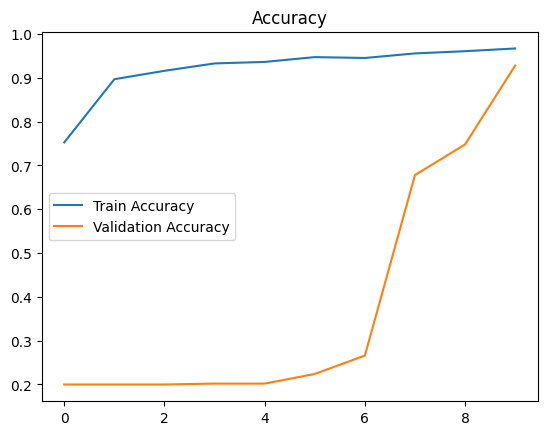

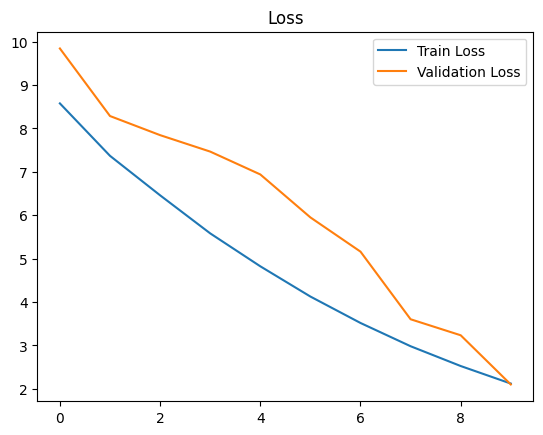

In [ ]:
# Plot accuracy
plt.plot(res_hist.history['accuracy'], label='Train Accuracy')
plt.plot(res_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(res_hist.history['loss'], label='Train Loss')
plt.plot(res_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step


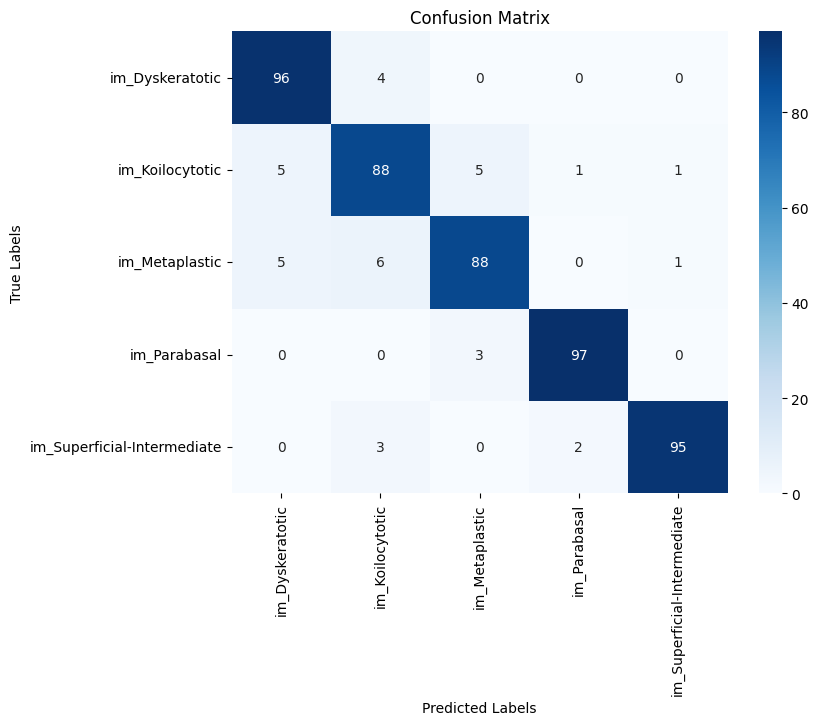

In [ ]:
# Confusion matrix
y_pred_prob = res_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.9056603773584906, 'recall': 0.96, 'f1-score': 0.9320388349514563, 'support': 100}, '1': {'precision': 0.8712871287128713, 'recall': 0.88, 'f1-score': 0.8756218905472637, 'support': 100}, '2': {'precision': 0.9166666666666666, 'recall': 0.88, 'f1-score': 0.8979591836734694, 'support': 100}, '3': {'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'support': 100}, '4': {'precision': 0.979381443298969, 'recall': 0.95, 'f1-score': 0.9644670050761421, 'support': 100}, 'accuracy': 0.928, 'macro avg': {'precision': 0.9285991232073995, 'recall': 0.9279999999999999, 'f1-score': 0.9280173828496663, 'support': 500}, 'weighted avg': {'precision': 0.9285991232073996, 'recall': 0.928, 'f1-score': 0.9280173828496663, 'support': 500}}


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
res_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for ResNet50: {:.4f}".format(res_roc_auc))

Macro-Averaged ROC-AUC for ResNet50: 0.9932


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


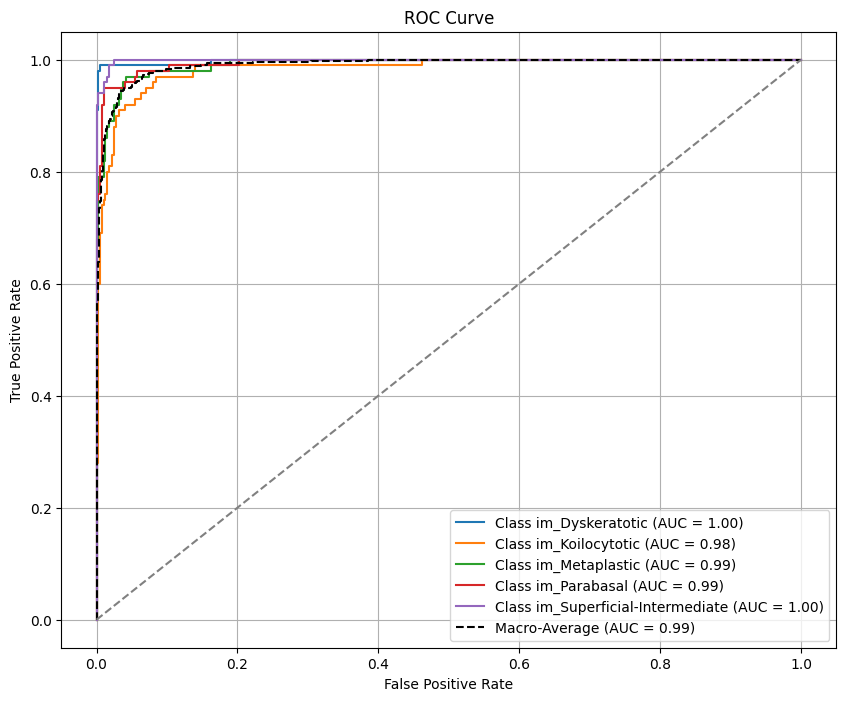

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
resnet_precision = report['weighted avg']['precision']
resnet_recall = report['weighted avg']['recall']
resnet_f1_score = report['weighted avg']['f1-score']

print("Precision: ", resnet_precision)
print("Recall: ", resnet_recall)
print("F1-Score: ", resnet_f1_score)

Precision:  0.9285991232073996
Recall:  0.928
F1-Score:  0.9280173828496663


In [ ]:
# Save the model
res_model.save('/kaggle/working/res_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# VGG16
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

vgg_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the Model
vgg_hist = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 152s 927ms/step - accuracy: 0.1941 - loss: 8.7923 - val_accuracy: 0.2020 - val_loss: 3.5895
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 419ms/step - accuracy: 0.1921 - loss: 3.1165 - val_accuracy: 0.2000 - val_loss: 2.3209
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 434ms/step - accuracy: 0.1920 - loss: 2.2168 - val_accuracy: 0.2000 - val_loss: 1.9943
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 421ms/step - accuracy: 0.1934 - loss: 1.9504 - val_accuracy: 0.2000 - val_loss: 1.8474
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 420ms/step - accuracy: 0.2074 - loss: 1.8242 - val_accuracy: 0.2000 - val_loss: 1.7688
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 420ms/step - accuracy: 0.2058 - loss: 1.7556 - val_accuracy: 0.2000 - val_loss: 1.7228
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 419ms/step - accuracy: 0.2092 - loss: 1.7146 - val_accuracy: 0.2000 - val_loss: 1.6939
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 421ms/step - accuracy: 0.1936 - loss: 

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_generator)
print("VGG16 Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.0419 - loss: 1.6505
VGG16 Test Accuracy: 20.000000298023224 %


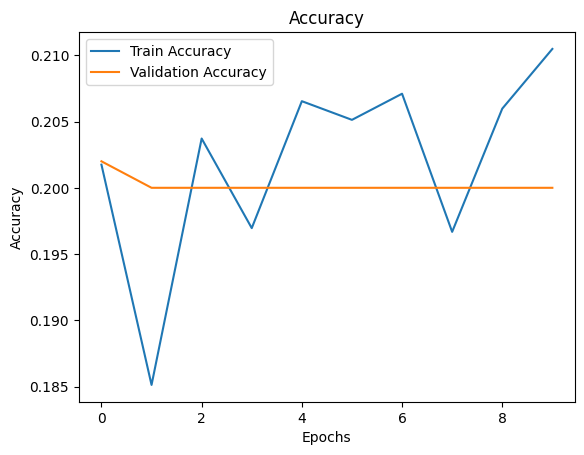

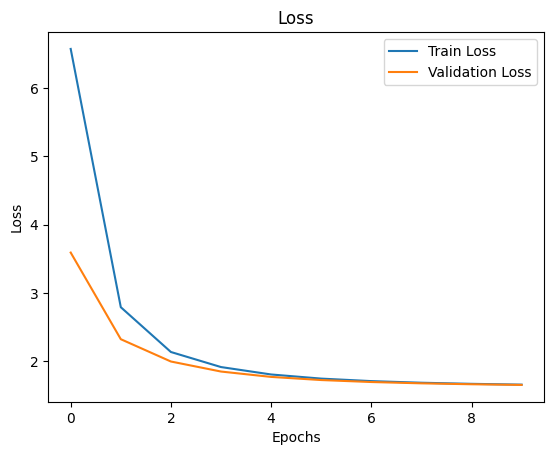

In [ ]:
# Plot accuracy
plt.plot(vgg_hist.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(vgg_hist.history['loss'], label='Train Loss')
plt.plot(vgg_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


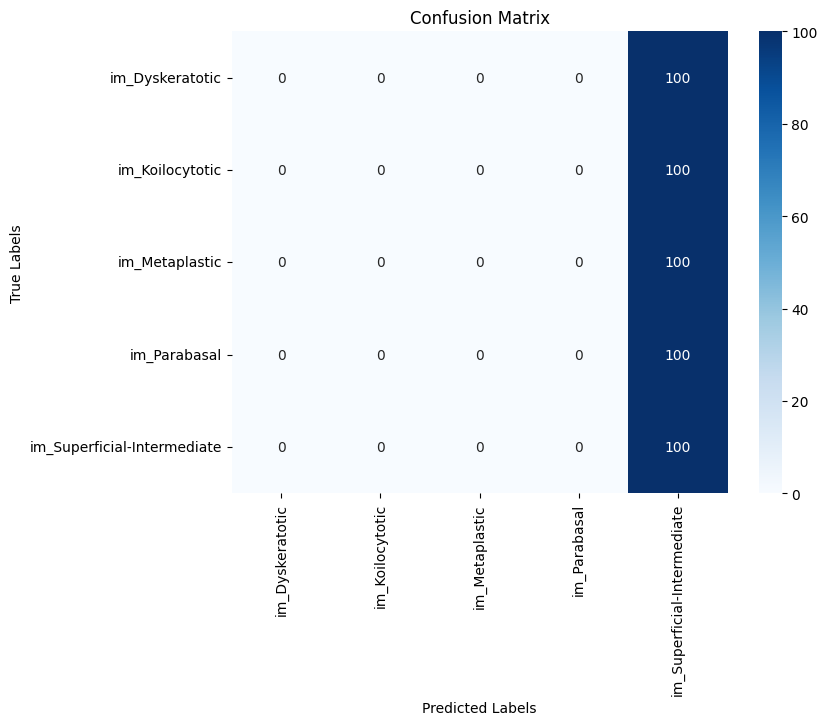

In [ ]:
# Confusion matrix
y_pred_prob = vgg_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '4': {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 100}, 'accuracy': 0.2, 'macro avg': {'precision': 0.04, 'recall': 0.2, 'f1-score': 0.06666666666666668, 'support': 500}, 'weighted avg': {'precision': 0.04, 'recall': 0.2, 'f1-score': 0.06666666666666667, 'support': 500}}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
vgg_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for VGG16: {:.4f}".format(vgg_roc_auc))

Macro-Averaged ROC-AUC for VGG16: 0.9932


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


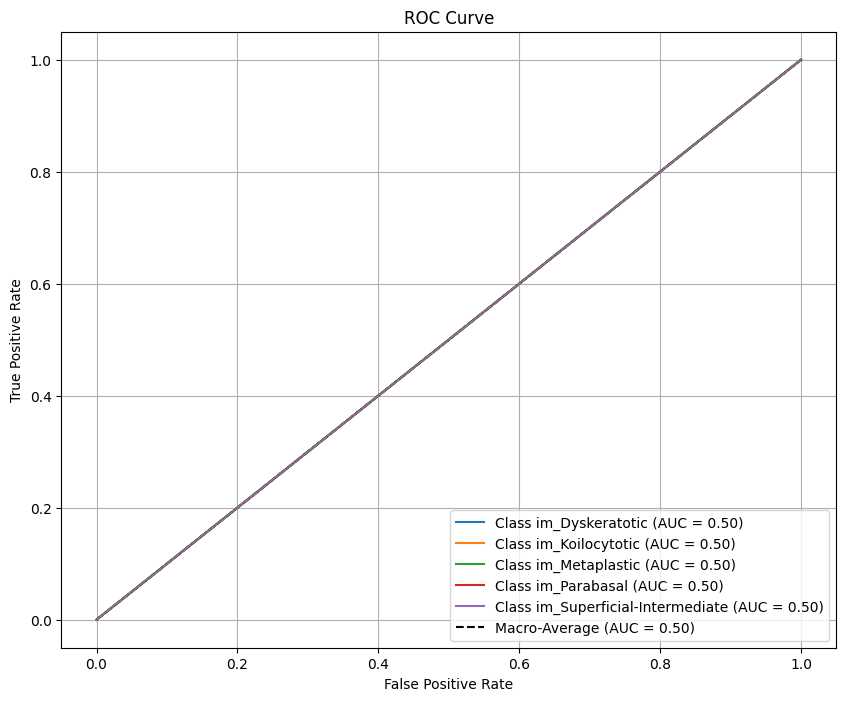

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
vgg_precision = report['weighted avg']['precision']
vgg_recall = report['weighted avg']['recall']
vgg_f1_score = report['weighted avg']['f1-score']

print("Precision: ", vgg_precision)
print("Recall: ", vgg_recall)
print("F1-Score: ", vgg_f1_score)

Precision:  0.04
Recall:  0.2
F1-Score:  0.06666666666666667


In [ ]:
# Save the model
vgg_model.save('/kaggle/working/vgg_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Inception
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

inc_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

inc_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the Model
inc_hist = inc_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 186s 912ms/step - accuracy: 0.5012 - loss: 20.5149 - val_accuracy: 0.6320 - val_loss: 15.8096
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.8425 - loss: 13.8646 - val_accuracy: 0.8560 - val_loss: 10.7545
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.8941 - loss: 9.7627 - val_accuracy: 0.9180 - val_loss: 7.5154
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 403ms/step - accuracy: 0.9094 - loss: 6.9225 - val_accuracy: 0.8900 - val_loss: 5.4720
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 402ms/step - accuracy: 0.9342 - loss: 4.9189 - val_accuracy: 0.9080 - val_loss: 3.9675
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accuracy: 0.9388 - loss: 3.5371 - val_accuracy: 0.8600 - val_loss: 3.0856
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 397ms/step - accuracy: 0.9534 - loss: 2.5652 - val_accuracy: 0.9180 - val_loss: 2.1296
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.9429 - lo

In [ ]:
test_loss, test_acc = inc_model.evaluate(test_generator)
print("InceptionV3 Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9418 - loss: 0.9831
InceptionV3 Test Accuracy: 94.19999718666077 %


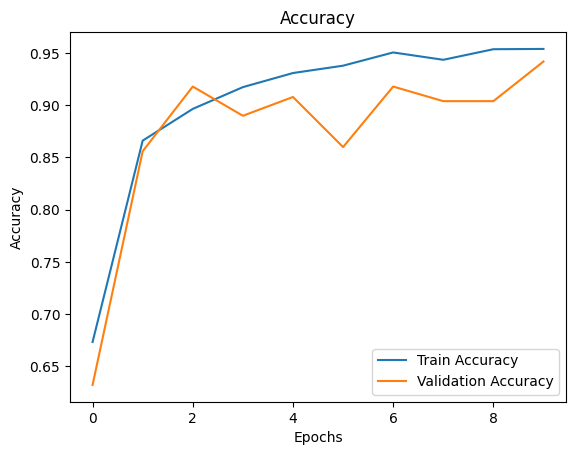

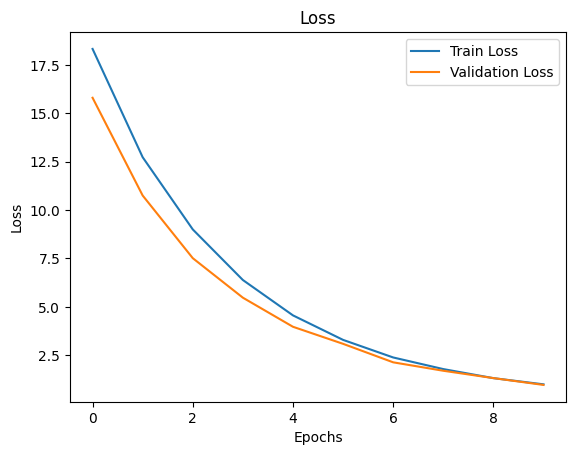

In [ ]:
# Plot accuracy
plt.plot(inc_hist.history['accuracy'], label='Train Accuracy')
plt.plot(inc_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(inc_hist.history['loss'], label='Train Loss')
plt.plot(inc_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step


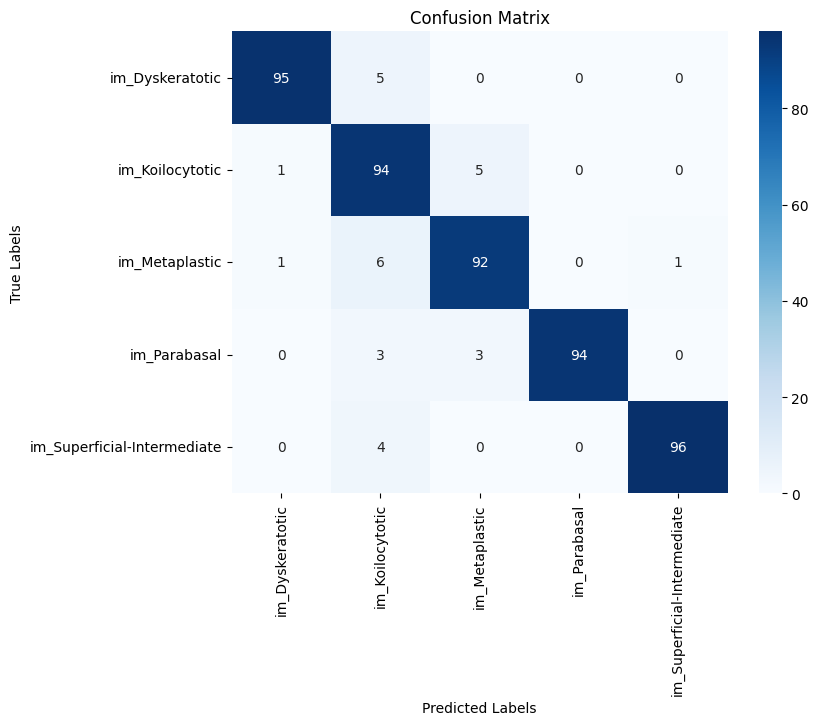

In [ ]:
# Confusion matrix
y_pred_prob = inc_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.979381443298969, 'recall': 0.95, 'f1-score': 0.9644670050761421, 'support': 100}, '1': {'precision': 0.8392857142857143, 'recall': 0.94, 'f1-score': 0.8867924528301886, 'support': 100}, '2': {'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'support': 100}, '3': {'precision': 1.0, 'recall': 0.94, 'f1-score': 0.9690721649484536, 'support': 100}, '4': {'precision': 0.9896907216494846, 'recall': 0.96, 'f1-score': 0.9746192893401014, 'support': 100}, 'accuracy': 0.942, 'macro avg': {'precision': 0.9456715758468336, 'recall': 0.942, 'f1-score': 0.9429901824389771, 'support': 500}, 'weighted avg': {'precision': 0.9456715758468336, 'recall': 0.942, 'f1-score': 0.942990182438977, 'support': 500}}


In [ ]:
# Plot ROC Curve
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
inc_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC FOR InceptionV3: {:.4f}".format(inc_roc_auc))

Macro-Averaged ROC-AUC FOR InceptionV3: 0.9932


/tmp/ipykernel_23/2191934111.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


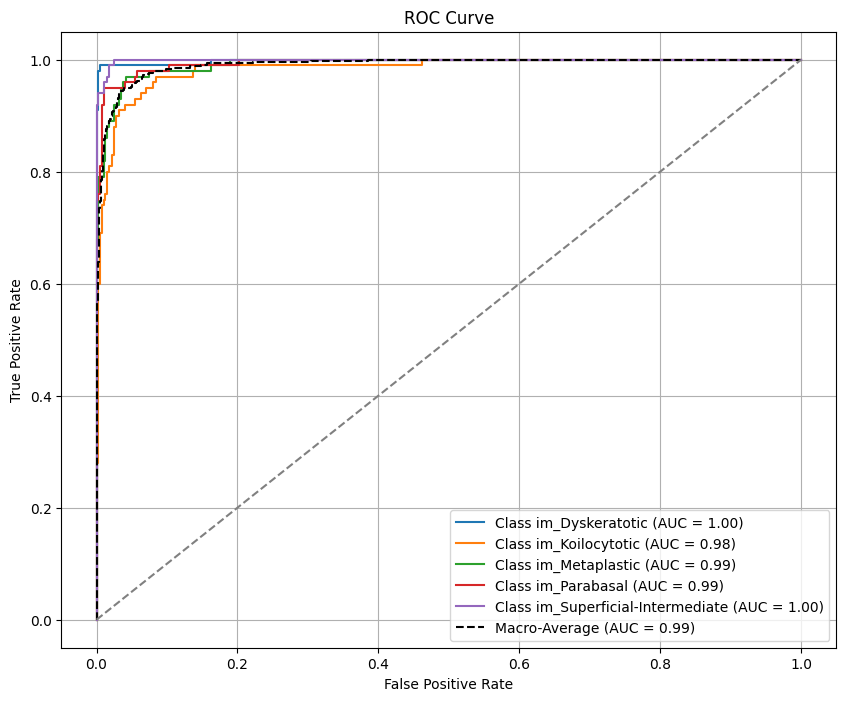

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
inc_precision = report['weighted avg']['precision']
inc_recall = report['weighted avg']['recall']
inc_f1_score = report['weighted avg']['f1-score']

print("Precision: ", inc_precision)
print("Recall: ", inc_recall)
print("F1-Score: ", inc_f1_score)

Precision:  0.9456715758468336
Recall:  0.942
F1-Score:  0.942990182438977


In [ ]:
# Save the model
inc_model.save('/kaggle/working/inc_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# EfficientNet B0 version
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

eff_b0_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

eff_b0_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the Model
eff_b0_hist = eff_b0_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 194s 946ms/step - accuracy: 0.5478 - loss: 11.9287 - val_accuracy: 0.2000 - val_loss: 10.6936
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 379ms/step - accuracy: 0.8834 - loss: 8.7622 - val_accuracy: 0.2040 - val_loss: 8.4472
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 381ms/step - accuracy: 0.9164 - loss: 6.5719 - val_accuracy: 0.2000 - val_loss: 7.1307
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.9169 - loss: 4.8919 - val_accuracy: 0.2120 - val_loss: 6.6146
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 409ms/step - accuracy: 0.9442 - loss: 3.5895 - val_accuracy: 0.2300 - val_loss: 5.5491
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step - accuracy: 0.9494 - loss: 2.6340 - val_accuracy: 0.2560 - val_loss: 4.9253
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 382ms/step - accuracy: 0.9452 - loss: 1.9566 - val_accuracy: 0.5860 - val_loss: 2.5945
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 384ms/step - accuracy: 0.9448 - loss

In [ ]:
test_loss, test_acc = eff_b0_model.evaluate(test_generator)
print("EfficientNet B0 version Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9220 - loss: 0.7792
EfficientNet B0 version Test Accuracy: 90.39999842643738 %


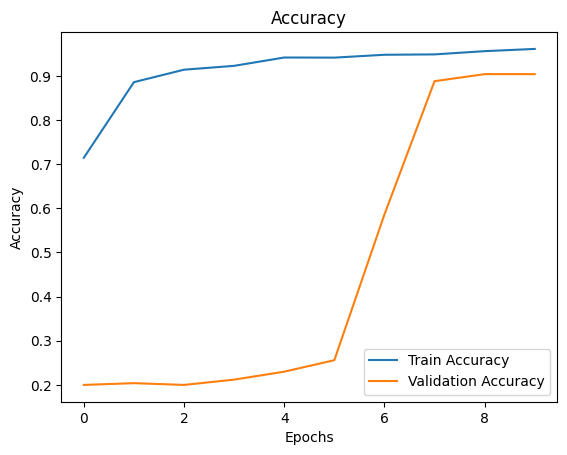

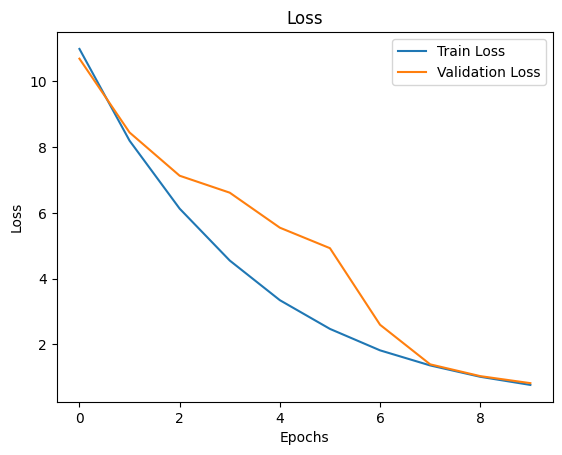

In [ ]:
# Plot accuracy
plt.plot(eff_b0_hist.history['accuracy'], label='Train Accuracy')
plt.plot(eff_b0_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(eff_b0_hist.history['loss'], label='Train Loss')
plt.plot(eff_b0_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step


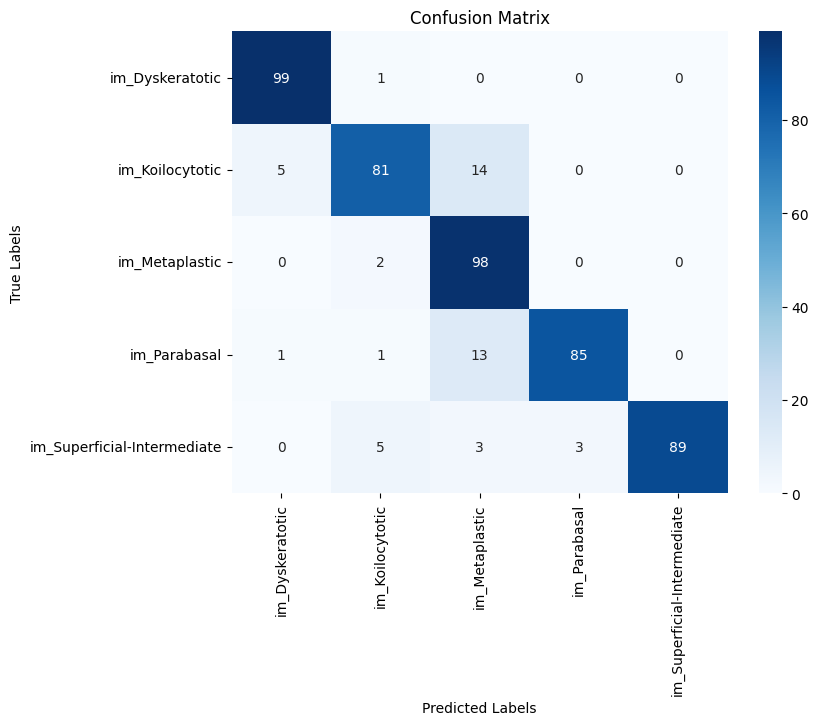

In [ ]:
# Confusion matrix
y_pred_prob = eff_b0_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.9428571428571428, 'recall': 0.99, 'f1-score': 0.9658536585365853, 'support': 100}, '1': {'precision': 0.9, 'recall': 0.81, 'f1-score': 0.8526315789473685, 'support': 100}, '2': {'precision': 0.765625, 'recall': 0.98, 'f1-score': 0.8596491228070174, 'support': 100}, '3': {'precision': 0.9659090909090909, 'recall': 0.85, 'f1-score': 0.9042553191489362, 'support': 100}, '4': {'precision': 1.0, 'recall': 0.89, 'f1-score': 0.9417989417989417, 'support': 100}, 'accuracy': 0.904, 'macro avg': {'precision': 0.9148782467532467, 'recall': 0.9040000000000001, 'f1-score': 0.9048377242477699, 'support': 500}, 'weighted avg': {'precision': 0.9148782467532467, 'recall': 0.904, 'f1-score': 0.9048377242477699, 'support': 500}}


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
eff_b0_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for EfficientNet version B0: {:.4f}".format(eff_b0_roc_auc))

Macro-Averaged ROC-AUC for EfficientNet version B0: 0.9932


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


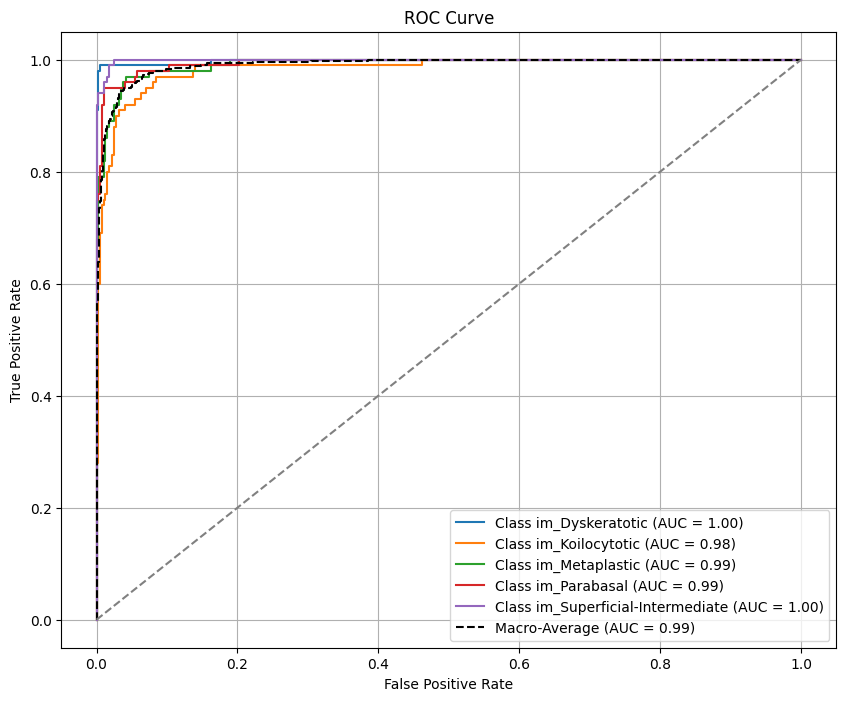

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
eff_b0_precision = report['weighted avg']['precision']
eff_b0_recall = report['weighted avg']['recall']
eff_b0_f1_score = report['weighted avg']['f1-score']

print("Precision: ", eff_b0_precision)
print("Recall: ", eff_b0_recall)
print("F1-Score: ", eff_b0_f1_score)

Precision:  0.9148782467532467
Recall:  0.904
F1-Score:  0.9048377242477699


In [ ]:
# Save the model
eff_b0_model.save('/kaggle/working/eff_b0_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# EfficientNet B7 version
from tensorflow.keras.applications import EfficientNetB7
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

eff_b7_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

eff_b7_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the Model
eff_b7_hist = eff_b7_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733312468.787300     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 24 bytes spill stores, 24 bytes spill loads



111/111 ━━━━━━━━━━━━━━━━━━━━ 836s 4s/step - accuracy: 0.5815 - loss: 14.6845 - val_accuracy: 0.2000 - val_loss: 12.4528
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 108s 945ms/step - accuracy: 0.9184 - loss: 9.9036 - val_accuracy: 0.2000 - val_loss: 10.3152
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 939ms/step - accuracy: 0.9329 - loss: 6.6562 - val_accuracy: 0.2000 - val_loss: 8.0605
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 938ms/step - accuracy: 0.9458 - loss: 4.3623 - val_accuracy: 0.2040 - val_loss: 6.2431
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 940ms/step - accuracy: 0.9608 - loss: 2.7921 - val_accuracy: 0.5980 - val_loss: 2.9770
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 939ms/step - accuracy: 0.9666 - loss: 1.7907 - val_accuracy: 0.6440 - val_loss: 2.2123
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 939ms/step - accuracy: 0.9637 - loss: 1.1593 - val_accuracy: 0.8340 - val_loss: 1.1797
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 940ms/step - accuracy: 0.9711 - loss: 0.74

In [ ]:
test_loss, test_acc = eff_b7_model.evaluate(test_generator)
print("EfficientNet B7 version Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9280 - loss: 0.4146
EfficientNet B7 version Test Accuracy: 92.1999990940094 %


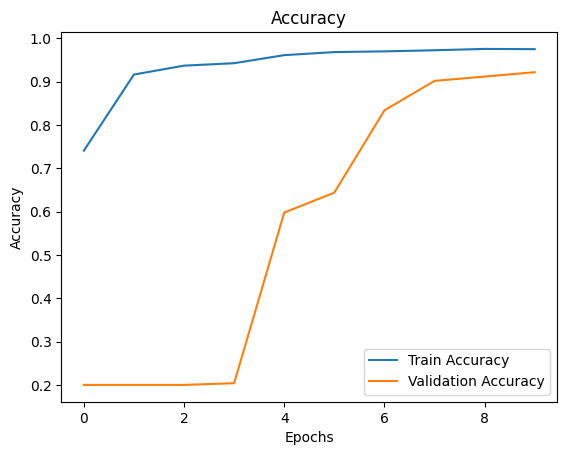

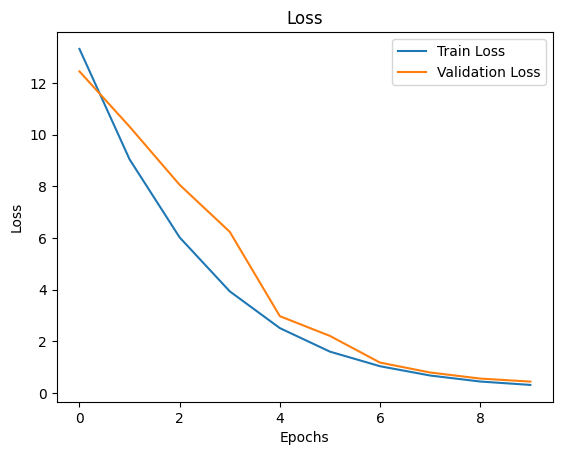

In [ ]:
# Plot accuracy
plt.plot(eff_b7_hist.history['accuracy'], label='Train Accuracy')
plt.plot(eff_b7_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(eff_b7_hist.history['loss'], label='Train Loss')
plt.plot(eff_b7_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 


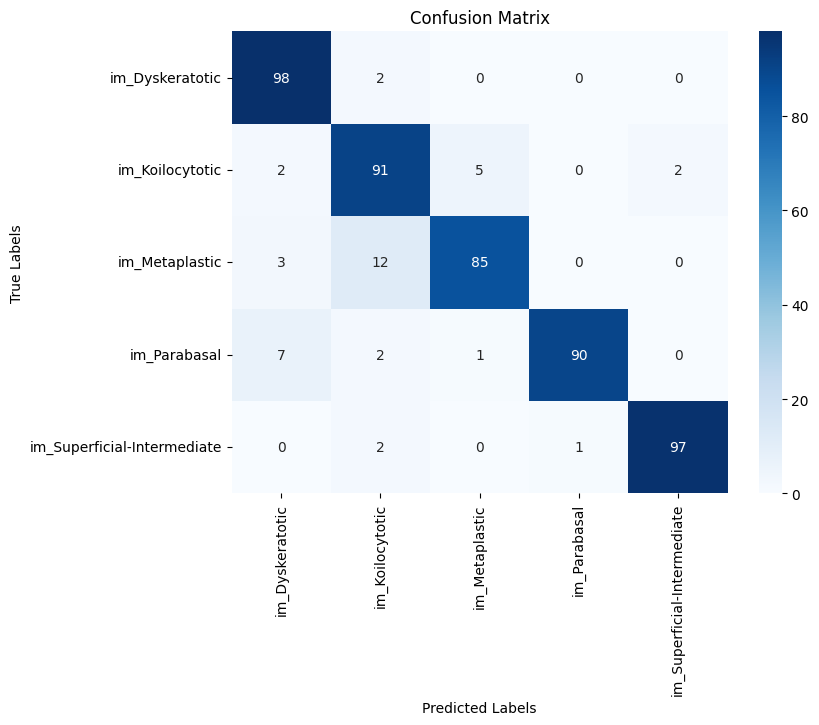

In [ ]:
# Confusion matrix
y_pred_prob = eff_b7_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.8909090909090909, 'recall': 0.98, 'f1-score': 0.9333333333333333, 'support': 100}, '1': {'precision': 0.8348623853211009, 'recall': 0.91, 'f1-score': 0.8708133971291867, 'support': 100}, '2': {'precision': 0.9340659340659341, 'recall': 0.85, 'f1-score': 0.8900523560209425, 'support': 100}, '3': {'precision': 0.989010989010989, 'recall': 0.9, 'f1-score': 0.9424083769633509, 'support': 100}, '4': {'precision': 0.9797979797979798, 'recall': 0.97, 'f1-score': 0.9748743718592964, 'support': 100}, 'accuracy': 0.922, 'macro avg': {'precision': 0.9257292758210189, 'recall': 0.922, 'f1-score': 0.9222963670612219, 'support': 500}, 'weighted avg': {'precision': 0.9257292758210189, 'recall': 0.922, 'f1-score': 0.922296367061222, 'support': 500}}


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
eff_b7_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for EfficientNet version B7: {:.4f}".format(eff_b7_roc_auc))

Macro-Averaged ROC-AUC for EfficientNet version B7: 0.9944


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


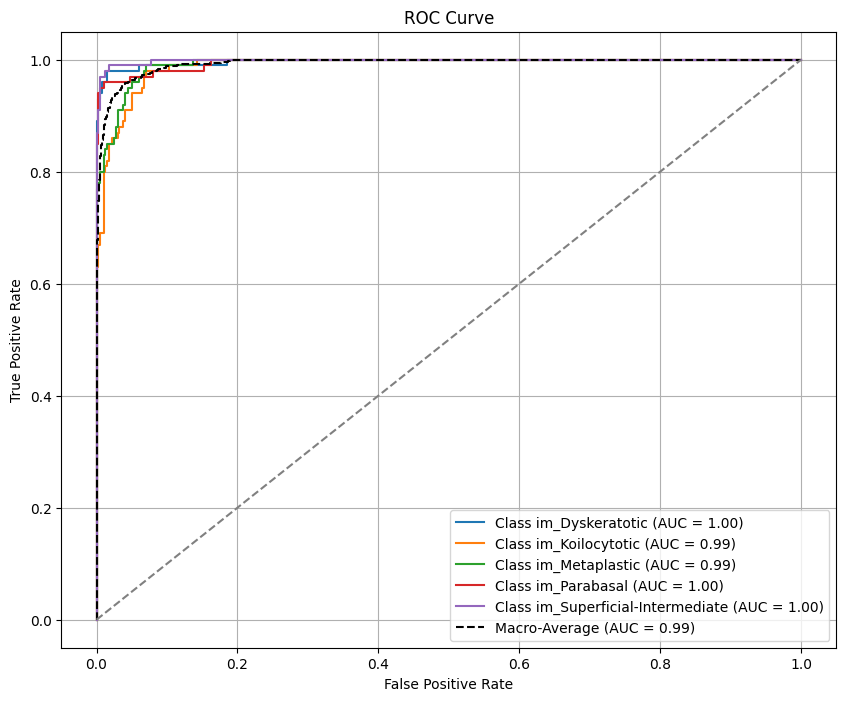

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
eff_b7_precision = report['weighted avg']['precision']
eff_b7_recall = report['weighted avg']['recall']
eff_b7_f1_score = report['weighted avg']['f1-score']

print("Precision: ", eff_b7_precision)
print("Recall: ", eff_b7_recall)
print("F1-Score: ", eff_b7_f1_score)

Precision:  0.9257292758210189
Recall:  0.922
F1-Score:  0.922296367061222


In [ ]:
# Save the model
eff_b7_model.save('/kaggle/working/eff_b7_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# MobileNetV2
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

mob_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

mob_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
mob_hist = mob_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 116s 616ms/step - accuracy: 0.5520 - loss: 12.2091 - val_accuracy: 0.4800 - val_loss: 11.7161
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 386ms/step - accuracy: 0.8647 - loss: 10.0308 - val_accuracy: 0.4480 - val_loss: 10.7763
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.8884 - loss: 8.5094 - val_accuracy: 0.3900 - val_loss: 9.3740
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 385ms/step - accuracy: 0.9219 - loss: 7.0726 - val_accuracy: 0.3360 - val_loss: 9.1274
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 399ms/step - accuracy: 0.9283 - loss: 5.8659 - val_accuracy: 0.3220 - val_loss: 7.7242
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 398ms/step - accuracy: 0.9308 - loss: 4.8255 - val_accuracy: 0.3680 - val_loss: 6.5487
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9324 - loss: 3.9519 - val_accuracy: 0.5020 - val_loss: 5.5640
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 393ms/step - accuracy: 0.9446 - lo

In [ ]:
test_loss, test_acc = mob_model.evaluate(test_generator)
print("MobileNetV2 Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5948 - loss: 3.0162
MobileNetV2 Test Accuracy: 51.20000243186951 %


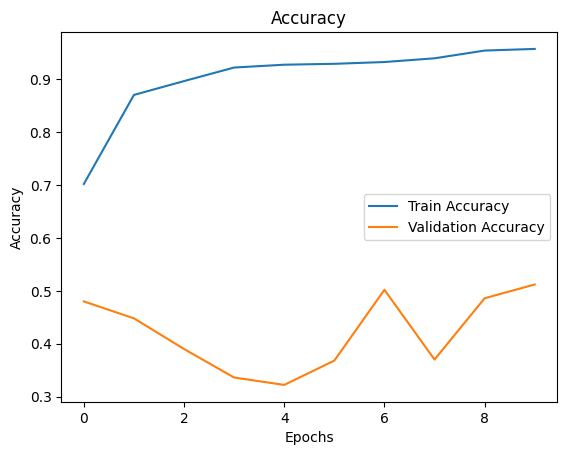

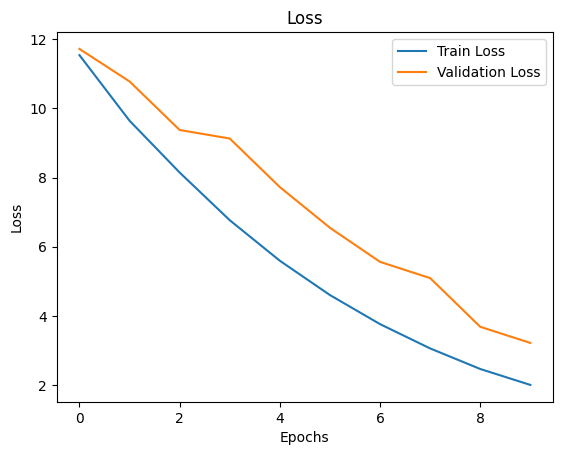

In [ ]:
# Plot accuracy
plt.plot(mob_hist.history['accuracy'], label='Train Accuracy')
plt.plot(mob_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(mob_hist.history['loss'], label='Train Loss')
plt.plot(mob_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step


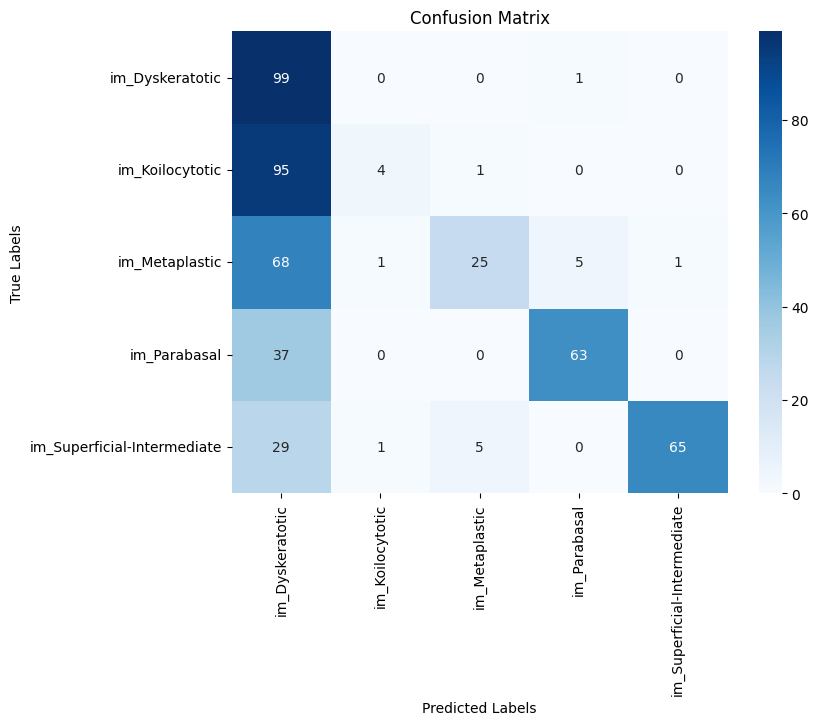

In [ ]:
# Confusion matrix
y_pred_prob = mob_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.3018292682926829, 'recall': 0.99, 'f1-score': 0.4626168224299066, 'support': 100}, '1': {'precision': 0.6666666666666666, 'recall': 0.04, 'f1-score': 0.07547169811320754, 'support': 100}, '2': {'precision': 0.8064516129032258, 'recall': 0.25, 'f1-score': 0.38167938931297707, 'support': 100}, '3': {'precision': 0.9130434782608695, 'recall': 0.63, 'f1-score': 0.7455621301775148, 'support': 100}, '4': {'precision': 0.9848484848484849, 'recall': 0.65, 'f1-score': 0.7831325301204819, 'support': 100}, 'accuracy': 0.512, 'macro avg': {'precision': 0.734567902194386, 'recall': 0.512, 'f1-score': 0.4896925140308176, 'support': 500}, 'weighted avg': {'precision': 0.734567902194386, 'recall': 0.512, 'f1-score': 0.48969251403081754, 'support': 500}}


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
mob_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for MobileNetV2: {:.4f}".format(mob_roc_auc))

Macro-Averaged ROC-AUC for MobileNetV2: 0.4579


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


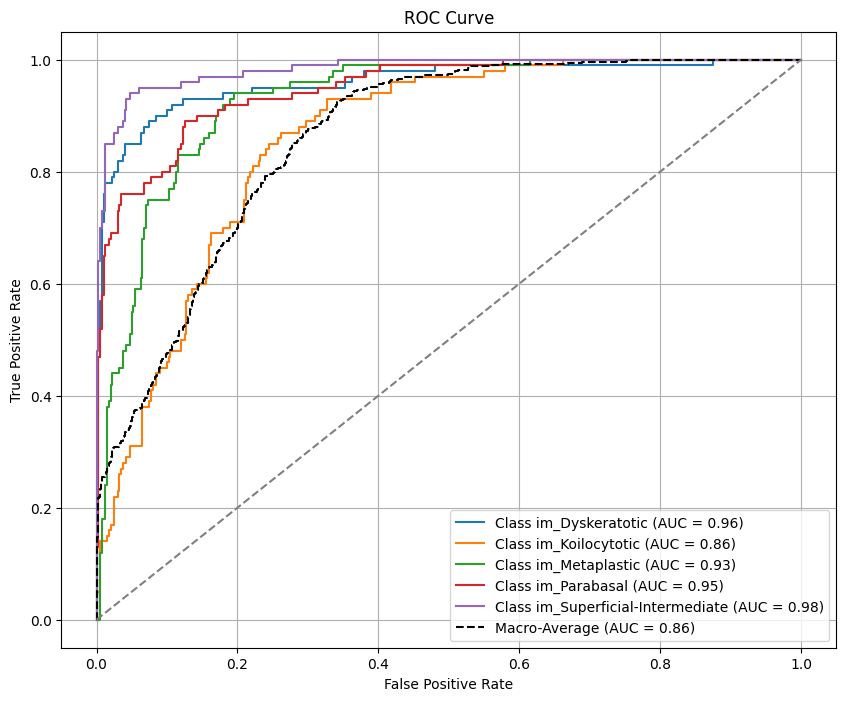

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
mob_precision = report['weighted avg']['precision']
mob_recall = report['weighted avg']['recall']
mob_f1_score = report['weighted avg']['f1-score']

print("Precision: ", mob_precision)
print("Recall: ", mob_recall)
print("F1-Score: ", mob_f1_score)

Precision:  0.734567902194386
Recall:  0.512
F1-Score:  0.48969251403081754


In [ ]:
# Save the model
mob_model.save('/kaggle/working/mob_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# MobileNetV3 Large
from tensorflow.keras.applications import MobileNetV3Large
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

mob_v3_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

mob_v3_model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mob_v3_hist = mob_v3_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 135s 694ms/step - accuracy: 0.4888 - loss: 10.8720 - val_accuracy: 0.1740 - val_loss: 10.4716
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step - accuracy: 0.8326 - loss: 8.8509 - val_accuracy: 0.2000 - val_loss: 9.2955
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 396ms/step - accuracy: 0.8815 - loss: 7.5218 - val_accuracy: 0.2000 - val_loss: 8.2100
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 385ms/step - accuracy: 0.9034 - loss: 6.3751 - val_accuracy: 0.2000 - val_loss: 7.3886
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 396ms/step - accuracy: 0.9312 - loss: 5.3420 - val_accuracy: 0.2000 - val_loss: 6.6461
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 378ms/step - accuracy: 0.9373 - loss: 4.4835 - val_accuracy: 0.2000 - val_loss: 6.0844
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 380ms/step - accuracy: 0.9286 - loss: 3.7748 - val_accuracy: 0.2000 - val_loss: 5.4332
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.9408 - loss

In [ ]:
test_loss, test_acc = mob_v3_model.evaluate(test_generator)
print("MobileNetV3 Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0883 - loss: 4.8837 
MobileNetV3 Test Accuracy: 20.000000298023224 %


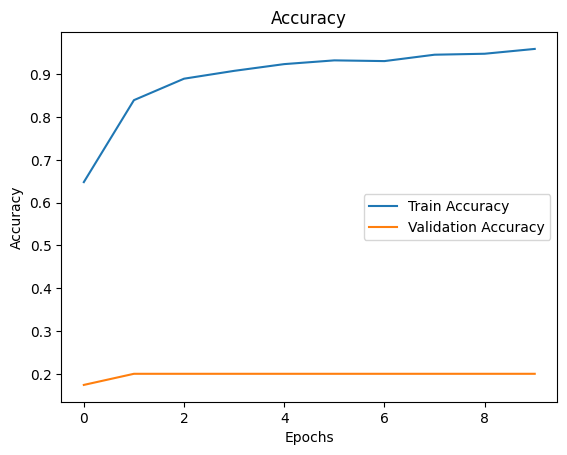

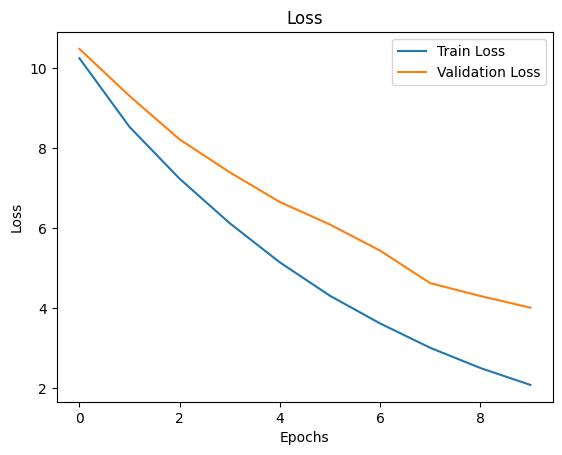

In [ ]:
# Plot accuracy
plt.plot(mob_v3_hist.history['accuracy'], label='Train Accuracy')
plt.plot(mob_v3_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(mob_v3_hist.history['loss'], label='Train Loss')
plt.plot(mob_v3_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


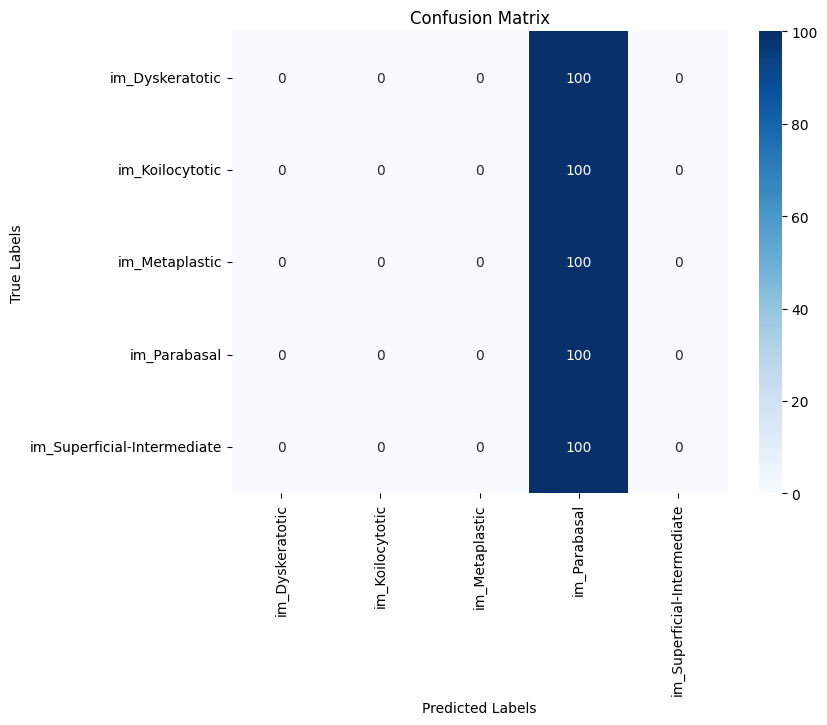

In [ ]:
# Confusion matrix
y_pred_prob = mob_v3_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, '3': {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 100}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, 'accuracy': 0.2, 'macro avg': {'precision': 0.04, 'recall': 0.2, 'f1-score': 0.06666666666666668, 'support': 500}, 'weighted avg': {'precision': 0.04, 'recall': 0.2, 'f1-score': 0.06666666666666667, 'support': 500}}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
mob_v3_roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC for MobileNetV3: {:.4f}".format(mob_v3_roc_auc))

Macro-Averaged ROC-AUC for MobileNetV3: 0.4579


/tmp/ipykernel_23/976383133.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


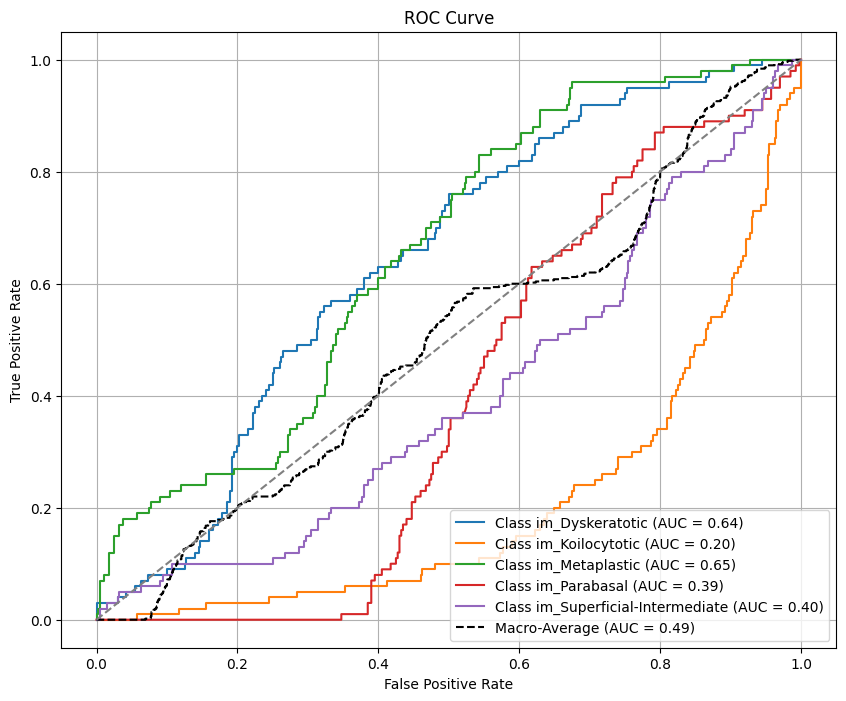

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
mob_v3_precision = report['weighted avg']['precision']
mob_v3_recall = report['weighted avg']['recall']
mob_v3_f1_score = report['weighted avg']['f1-score']

print("Precision: ", mob_v3_precision)
print("Recall: ", mob_v3_recall)
print("F1-Score: ", mob_v3_f1_score)

Precision:  0.04
Recall:  0.2
F1-Score:  0.06666666666666667


In [ ]:
# Save the model
mob_v3_model.save('/kaggle/working/mob_v3_model.h5')
print("Model saved successfully!")

Model saved successfully!


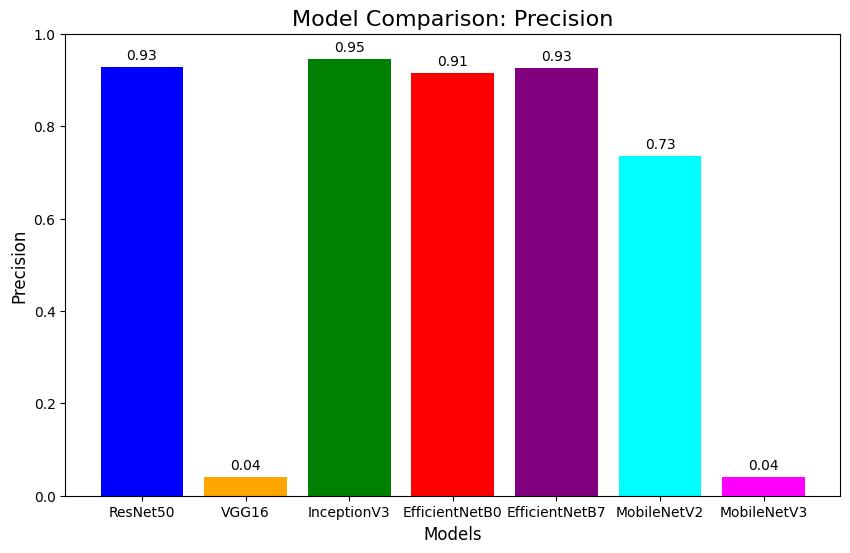

In [ ]:
# Create the bar plot to compare precision
models = ['ResNet50', 'VGG16', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB7', 'MobileNetV2', 'MobileNetV3']
precisions = [resnet_precision, vgg_precision, inc_precision, eff_b0_precision, eff_b7_precision, mob_precision, mob_v3_precision]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, precisions, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta'])
plt.title('Model Comparison: Precision', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()

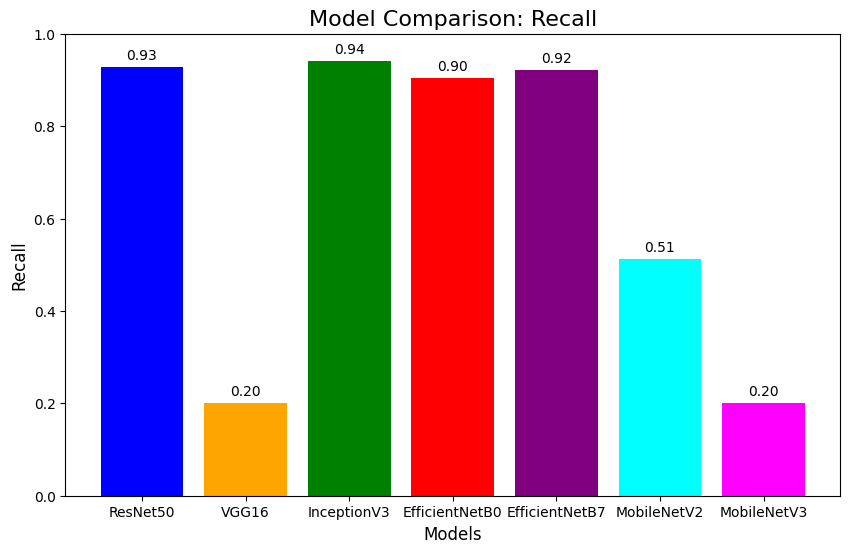

In [ ]:
# Create the bar plot to compare recall
models = ['ResNet50', 'VGG16', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB7', 'MobileNetV2', 'MobileNetV3']
recalls = [resnet_recall, vgg_recall, inc_recall, eff_b0_recall, eff_b7_recall, mob_recall, mob_v3_recall]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, recalls, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta'])
plt.title('Model Comparison: Recall', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()

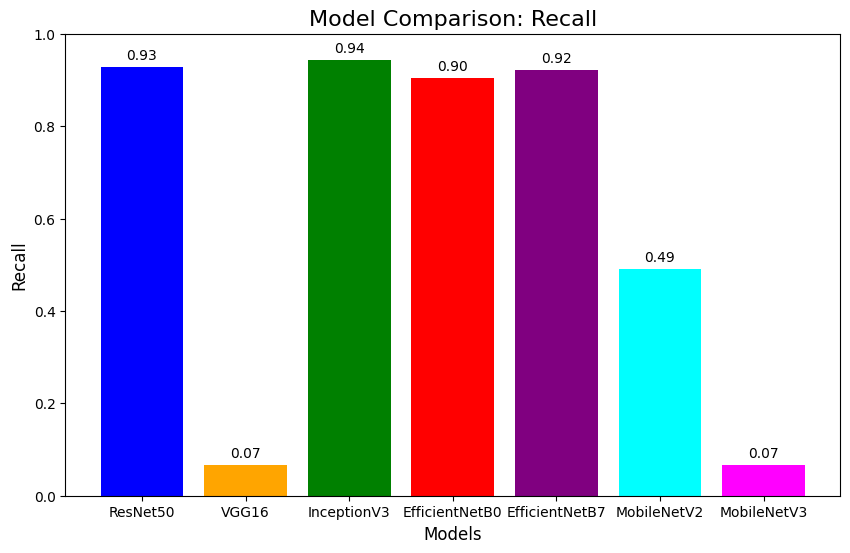

In [ ]:
# Create the bar plot to compare f1-score
models = ['ResNet50', 'VGG16', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB7', 'MobileNetV2', 'MobileNetV3']
f1-scores = [resnet_f1_score, vgg_f1_score, inc_f1_score, eff_b0_f1_score, eff_b7_f1_score, mob_f1_score, mob_v3_f1_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1-scores, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta'])
plt.title('Model Comparison: F1-score', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9250 - loss: 2.1115
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.0419 - loss: 1.6505
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9418 - loss: 0.9831
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9220 - loss: 0.7792
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9280 - loss: 0.4146
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5948 - loss: 3.0162
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0883 - loss: 4.8837  


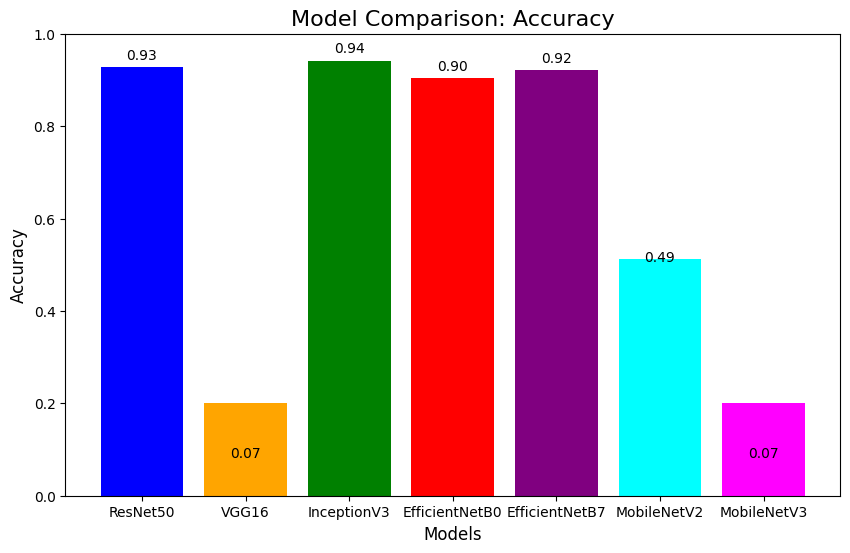

In [ ]:
# Create the bar plot to compare accuracy
resnet_loss, resnet_accuracy = res_model.evaluate(test_generator)
vgg_loss, vgg_accuracy = vgg_model.evaluate(test_generator)
inc_loss, inc_accuracy = inc_model.evaluate(test_generator)
eff_b0_loss, eff_b0_accuracy = eff_b0_model.evaluate(test_generator)
eff_b7_loss, eff_b7_accuracy = eff_b7_model.evaluate(test_generator)
mob_loss, mob_accuracy = mob_model.evaluate(test_generator)
mob_v3_loss, mob_v3_accuracy = mob_v3_model.evaluate(test_generator)

models = ['ResNet50', 'VGG16', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB7', 'MobileNetV2', 'MobileNetV3']
accuracies = [resnet_accuracy, vgg_accuracy, inc_accuracy, eff_b0_accuracy, eff_b7_accuracy, mob_accuracy, mob_v3_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta'])
plt.title('Model Comparison: Accuracy', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()